# Stata Navigation Project

## Project Outline

* [Load and Test Pretrained Places365 Model](#load-and-test-pretrained-places365-model)
* [Load and Process Images of Stata](#load-and-process-images-of-stata)
* Retrain Places365 Model
* Test Results

## Load and Test Pretrained Places365 Model

In [41]:
#imports
import torch
from torchvision import models, transforms
from PIL import Image
import urllib
import os

In [42]:
# Initialize the model
model = models.resnet50(num_classes=365)

#If GPU is available, load the model to GPU
if torch.cuda.is_available():
    model = model.to('cuda')
else:
    model = model.to('cpu')

model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
# Download the pre-trained model weights if they do not exist
# It is necessary to first download the weights to a local cache directory bc of torchvision's model loading mechanism
weight_url = "http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar"
cache_dir = os.path.expanduser('~/.cache/places365')
os.makedirs(cache_dir, exist_ok=True)

weights_filepath = os.path.join(cache_dir, 'resnet50_places365.pth.tar')
if not os.path.exists(weights_filepath):
    urllib.request.urlretrieve(weight_url, weights_filepath)

# Load the model weights
checkpoint = torch.load(weights_filepath, map_location='cpu')
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [44]:
# Load the model classes
classes_url = "https://raw.githubusercontent.com/CSAILVision/places365/refs/heads/master/categories_places365.txt"
classes_filepath = os.path.join(cache_dir, 'categories_places365.txt')

with urllib.request.urlopen(classes_url) as response:
    classes = [line.decode('utf-8').strip().split(' ')[0][3:] for line in response]
    
classes = tuple(classes)

In [45]:
# Define an image preprocessing function
# The model expects images of size 224x224 and normalized with ImageNet statistics
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]    # ImageNet stds
    )
])

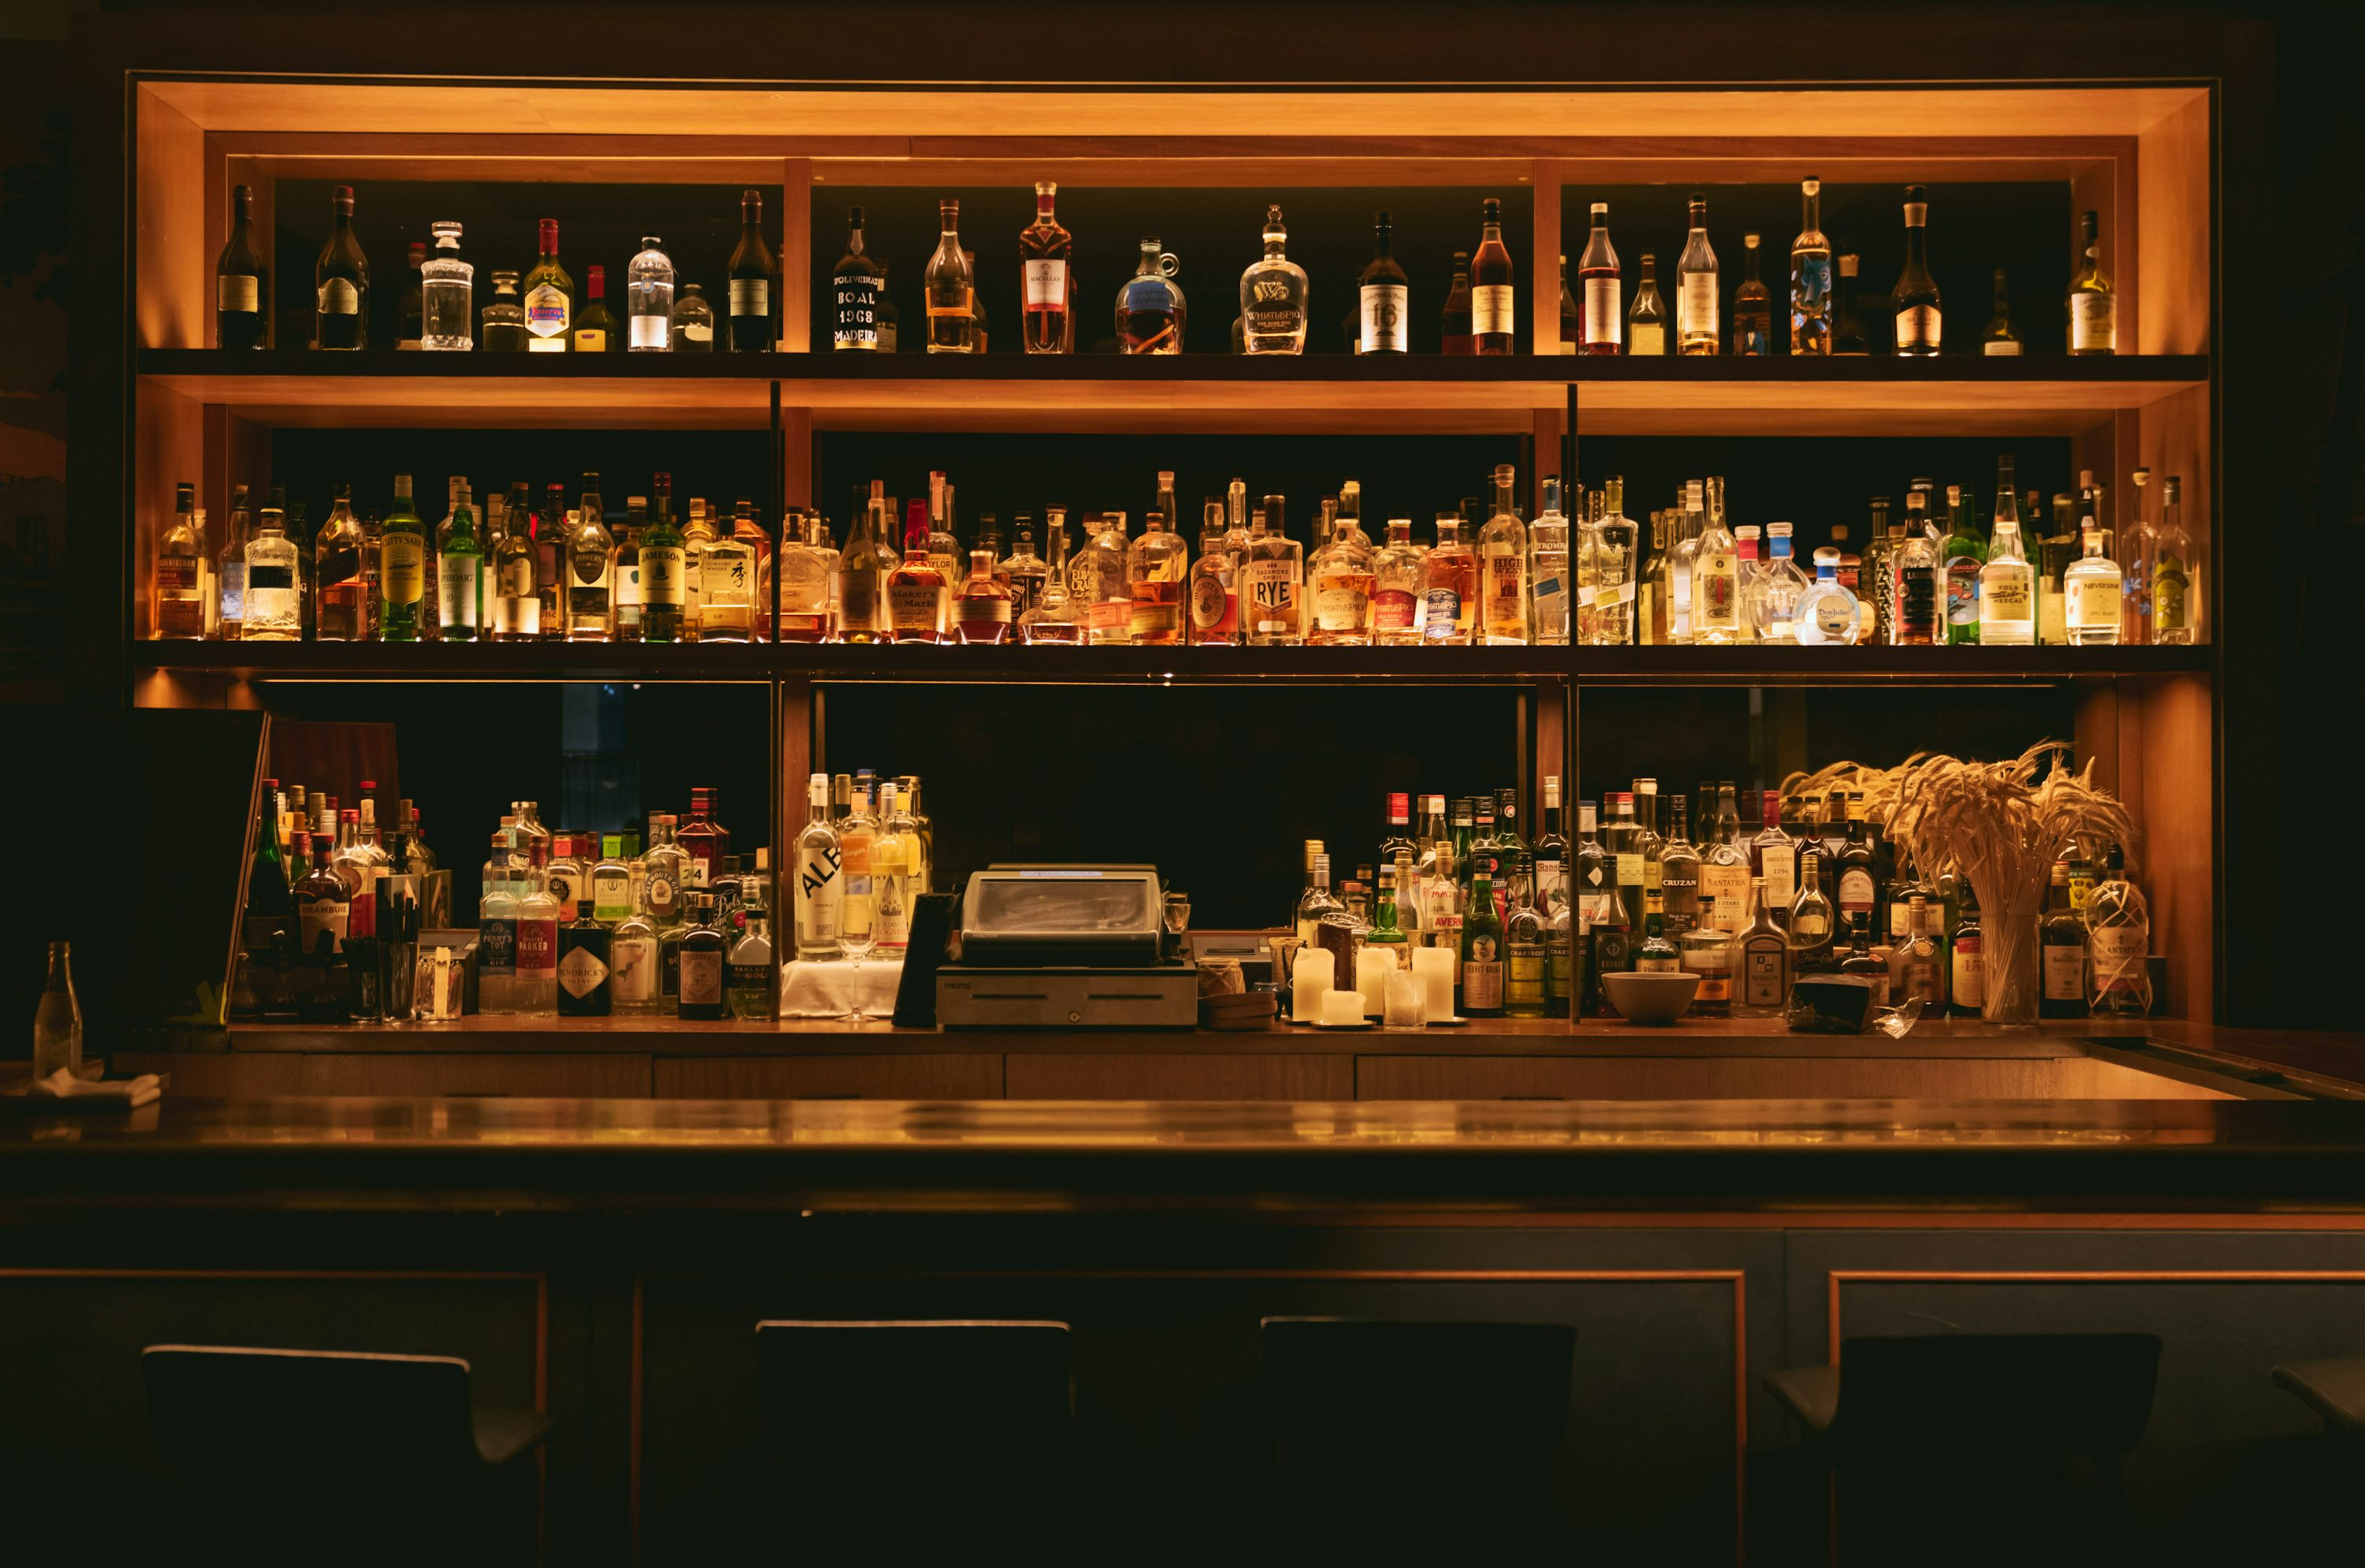

In [53]:
# Load an image from a URL image address
image_url = 'https://images.unsplash.com/photo-1597290282695-edc43d0e7129?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8YmFyfGVufDB8fDB8fHww'  # replace with your image URL
img = Image.open(urllib.request.urlopen(image_url)).convert('RGB')
img

In [54]:
# Preprocess the image
input_img = transform(img).unsqueeze(0)  # add batch dimension

In [47]:
#Run the model on the input image
# Forward pass
with torch.no_grad():
    logits = model(input_img)
    probs = torch.nn.functional.softmax(logits, dim=1)

# Get the top-5 predictions
top5_probs, top5_idxs = probs.topk(5)

print("Top 5 predicted places:")
for prob, idx in zip(top5_probs[0], top5_idxs[0]):
    print(f"{classes[idx]} ({prob.item():.4f})")

Top 5 predicted places:
bar (0.7915)
pharmacy (0.1112)
beer_hall (0.0362)
sushi_bar (0.0170)
drugstore (0.0123)


## Load and Process Images of Stata